# CS 585 HW 1

**Due:** 11:59 PM (at midnight) EST, Wednesday, February 14, 2024

**Completed By:**
* Muhammad Aseef Imran
* Munir Siddiqui

In [1]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from typing import Any
from numpy import ndarray, dtype, generic
from cv2 import Mat, UMat
from cv2 import VideoCapture

In [2]:
webcam = cv.VideoCapture(0)

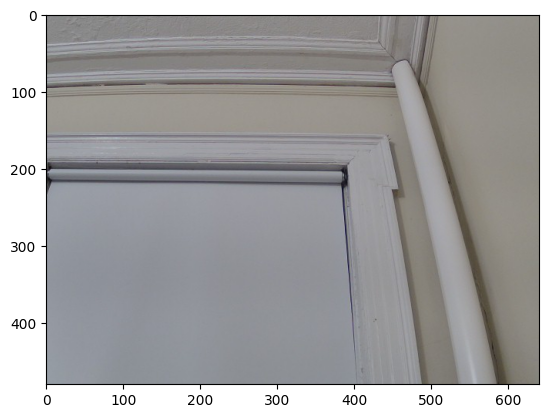

In [3]:
success, frame = webcam.read()
if success:
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    plt.imshow(frame)
    plt.plot()

In [4]:
def rescaleFrame(frame: Mat | ndarray[Any, dtype[generic]] | ndarray, scale) -> UMat:
    height = int(frame.shape[0] * scale)
    width = int(frame.shape[1] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

In [5]:
def setResLiveVideo(frame: VideoCapture, width: int):
    # given the width we automatically figure out the height
    scale = width / frame.get(3)
    height = int(frame.get(4) * scale)
    webcam.set(3, width)
    webcam.set(4, height)

In [8]:
# rescale frame for faster computation
setResLiveVideo(webcam, 400)

In [9]:
def calc_area(img: np.ndarray):
    return np.count_nonzero(img)

In [10]:
def find_centroid(img: np.ndarray):
    area = calc_area(img)
    # calculate the first moment
    m10 = 0
    m01 = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > 0:
                m10 += i
                m01 += j
    # calculate the centroid
    x = m10 / area
    y = m01 / area
    # draw a dot at the centroid
    img = cv.circle(img, (int(y), int(x)), 5, (0, 255, 0), -1)
    return (x, y)

In [11]:
def find_axis_of_least_inertia(img: np.ndarray):
    # calc first moments
    x, y = find_centroid(img)
    # calculate the second moments
    m11 = 0
    m20 = 0
    m02 = 0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i, j] > 0:
                m11 += (i - x) * (j - y)
                m20 += (i - x) ** 2
                m02 += (j - y) ** 2
    # calculate the angle of least inertia
    theta = 0.5 * np.arctan2(2 * m11, m20 - m02)
    # draw the angle line with midpoint at centroid
    x1 = int(x + 100 * np.cos(theta))
    y1 = int(y + 100 * np.sin(theta))
    x2 = int(x - 100 * np.cos(theta))
    y2 = int(y - 100 * np.sin(theta))

    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    img = cv.line(img, (y1, x1), (y2, x2), (0, 255, 0), 2)
    cv.putText(img, f'{theta}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    cv.imshow("Angle of Least Inertia", img)

    # rotate such that the line of least inertia is horizontally flat
    (rows, cols, _) = img.shape
    M = cv.getRotationMatrix2D((cols/2, rows/2), -math.degrees(theta), 1)
    img = cv.warpAffine(img, M, (cols, rows))
    cv.imshow("Post rotation", img)

    print(f'Angle of least inertia: {theta} {math.degrees(theta)}')
    return theta

In [13]:
import math

while True:
    success, frame = webcam.read()
    if not success:
        print('Failed to capture frame')
        break

    #cv.imshow("Original", frame)

    # convert the video frame into a binary image
    # so that all pixels that look like skin color
    # are included in the binary object
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    # use tolerant bounds
    lower = np.array([0, 36, 67], dtype='uint8')
    upper = np.array([25, 255, 255], dtype='uint8')
    mask = cv.inRange(hsv, lower, upper)
    frame = cv.bitwise_and(frame, frame, mask=mask)

    # smooth out the image via median blur (take the median of surrounding pixels)
    # effective for removing the noise
    frame = cv.medianBlur(frame,13)

    #cv.imshow('Video 1', frame)

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    _, thres_output = cv.threshold(gray, 20, 255, cv.THRESH_BINARY)

    # find largest object in the binary image
    contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

    if len(contours) == 0:
        continue

    # draw the largest object
    if len(contours) > 0:
        x, y, w, h = cv.boundingRect(contours[0])
        thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)

    # get rid of everything except the largest object
    mask = np.zeros(thres_output.shape, dtype=np.uint8)
    cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
    thres_output = cv.bitwise_and(thres_output, mask)
    # fill holes in the contour
    cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))

    theta = find_axis_of_least_inertia(thres_output)

    #cv.imshow("Video 1", thres_output)

    if cv.waitKey(20) & 0xFF==ord('d'):
        break

Angle of least inertia: 0.2673169761043804 15.316134522980475
Angle of least inertia: 0.2686012653851145 15.38971887844043
Angle of least inertia: 0.2688069906434911 15.40150606748465
Angle of least inertia: 0.26841732676163427 15.379179971625568
Angle of least inertia: 0.2673255013283619 15.31662298233402
Angle of least inertia: 0.2668194828720594 15.287630260432161
Angle of least inertia: 0.26738649942296583 15.320117915713164
Angle of least inertia: 0.2675755803446052 15.330951454509544
Angle of least inertia: 0.2674386905428996 15.32310824661343
Angle of least inertia: 0.2676442114700259 15.334883728339381
Angle of least inertia: 0.2681888530557249 15.366089392547247
Angle of least inertia: 0.2685425405340655 15.38635419232279
Angle of least inertia: 0.2679441822042975 15.352070785390586
Angle of least inertia: 0.2679270702393661 15.351090342020843
Angle of least inertia: 1.5008998232322264 85.99522534313788
Angle of least inertia: 1.535921912844038 88.00184326762364
Angle of least

Traceback (most recent call last):
  File "C:\Users\aseef\Desktop\CS585\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\aseef\AppData\Local\Temp\ipykernel_22700\3084945453.py", line 49, in <module>
    theta = find_axis_of_least_inertia(thres_output)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aseef\AppData\Local\Temp\ipykernel_22700\360452909.py", line 3, in find_axis_of_least_inertia
    x, y = find_centroid(img)
           ^^^^^^^^^^^^^^^^^^
  File "C:\Users\aseef\AppData\Local\Temp\ipykernel_22700\827375153.py", line -1, in find_centroid
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\aseef\Desktop\CS585\venv\Lib\site-packages\IPython\core\interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^